In [4]:
import pandas as pd

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import load_model

from keras_tuner import Hyperband

from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('data/imu_data_v2.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   attitude.roll        90000 non-null  float64
 1    attitude.pitch      90000 non-null  float64
 2    attitude.yaw        90000 non-null  float64
 3    gravity.x           90000 non-null  float64
 4    gravity.y           90000 non-null  float64
 5    gravity.z           90000 non-null  float64
 6    rotationRate.x      90000 non-null  float64
 7    rotationRate.y      90000 non-null  float64
 8    rotationRate.z      90000 non-null  float64
 9    userAcceleration.x  90000 non-null  float64
 10   userAcceleration.y  90000 non-null  float64
 11   userAcceleration.z  90000 non-null  float64
 12   magnetic.x          90000 non-null  float64
 13   magnetic.y          90000 non-null  float64
 14   magnetic.z          90000 non-null  float64
 15   temperature         90000 non-null 

In [6]:
df.head()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,magnetic.x,magnetic.y,magnetic.z,temperature,Target
0,-0.031761,-0.012218,0.003003,0.000213,-0.000554,1.000000,0.049162,0.191586,0.999767,0.270545,3.586514,9.248801,-73.32364,-75.95215,-36.22441,36.65579,0
1,-0.297625,-0.136795,0.029484,0.002388,-0.005195,0.999984,0.106185,0.160677,1.004430,0.306458,3.533842,9.337387,-78.47227,-76.84570,-38.11289,36.46410,0
2,-0.303267,-0.122350,0.029472,0.002135,-0.005293,0.999984,0.140026,0.140426,1.005097,0.292093,3.708618,9.397242,-78.47227,-76.84570,-38.11289,36.51202,0
3,-0.294682,-0.134588,0.029417,0.002349,-0.005143,0.999984,0.227959,0.193452,1.002432,0.337582,3.677494,9.042900,-78.47227,-76.84570,-38.11289,36.32034,0
4,-0.268240,-0.180387,0.028701,0.003148,-0.004682,0.999984,0.172268,0.301902,0.975119,0.502782,3.624821,8.860941,-78.47227,-76.84570,-38.11289,36.32034,0


In [7]:
df.describe()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,magnetic.x,magnetic.y,magnetic.z,temperature,Target
count,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000
mean,-0.176812,0.042908,0.002457,-0.000749,-0.003086,0.999977,0.038218,0.046098,0.092366,-0.192278,2.282397,9.039771,-39.006799,-23.361069,-77.678684,36.155768,3.133333
std,0.141829,0.309556,0.012808,0.005403,0.002475,0.000038,0.253233,0.240261,0.452221,1.235364,1.948453,1.054575,43.449201,39.877181,53.974354,0.353929,2.006667
min,-2.104751,-3.072426,-0.182044,-0.034817,-0.036713,0.998546,-2.461714,-2.916165,-2.638911,-6.840234,-3.830723,-2.442086,-188.191400,-211.236300,-218.719900,35.266030,0.000000
25%,-0.254502,-0.197593,-0.000726,-0.004632,-0.004442,0.999983,-0.010925,-0.025847,-0.015721,-0.799663,1.077391,8.726865,-64.801760,-46.822270,-124.639500,35.889030,1.000000
50%,-0.169656,0.153059,0.000604,-0.002671,-0.002961,0.999983,0.033175,0.015055,0.020784,-0.268151,2.475605,9.143456,-28.761330,-15.369140,-68.500200,36.080720,3.000000
75%,-0.068392,0.265380,0.002746,0.003449,-0.001194,0.999988,0.081138,0.082603,0.103254,0.445321,3.469198,9.363723,-9.054493,10.901370,-33.305860,36.320340,5.000000
max,0.020224,1.995269,0.427084,0.053598,0.000353,1.000000,2.547914,2.804518,3.518371,8.501810,9.737218,18.581400,127.650600,45.035160,125.497900,37.326710,6.000000


In [8]:
df.columns = ['attitude.roll', 'attitude.pitch', 'attitude.yaw', 'gravity.x',
       'gravity.y', 'gravity.z', 'rotationRate.x', 'rotationRate.y',
       'rotationRate.z', 'userAcceleration.x', 'userAcceleration.y',
       'userAcceleration.z', 'magnetic.x', 'magnetic.y', 'magnetic.z',
       'temperature', 'Target']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('Target', axis=1),
    df['Target'],
    test_size=0.15,
    random_state=42,
    stratify=df['Target']
)

In [10]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(76500, 16) (13500, 16) (76500,) (13500,)


In [9]:
def build_model(hp):
    layer_count = 0

    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))

    for i in range(hp.Int('num_layers_1', 1, 7)):
        model.add(Dense(
            units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32),
            activation='relu'
        ))
        layer_count += 1
    
    model.add(Dense(hp.Int(f'units_{layer_count}', min_value=32, max_value=512, step=32), activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    layer_count += 1

    for i in range(hp.Int('num_layers_2', 1, 5)):
        model.add(Dense(
            units=hp.Int(f'units_{i + layer_count}', min_value=32, max_value=512, step=32),
            activation='relu'
        ))
    
    model.add(Dense(7, activation='softmax'))
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])
    
    return model

In [10]:
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=15,
    directory='tuner',
    project_name='activity_recognition_v2'
)

tuner.search(X_train, y_train, validation_data=(X_test, y_test))

Trial 30 Complete [00h 02m 16s]
val_accuracy: 0.9670370221138

Best val_accuracy So Far: 0.9765926003456116
Total elapsed time: 01h 04m 13s


In [11]:
model = tuner.get_best_models(num_models=1)[0]
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 320)               5440      
                                                                 
 dense_1 (Dense)             (None, 288)               92448     
                                                                 
 dense_2 (Dense)             (None, 384)               110976    
                                                                 
 dense_3 (Dense)             (None, 416)               160160    
                                                                 
 dense_4 (Dense)             (None, 384)               160128    
                                                                 
 dense_5 (Dense)             (None, 224)               86240     
                                                                 
 dense_6 (Dense)             (None, 224)               5

In [12]:
history = model.fit(X_train, y_train, epochs=35, validation_data=(X_test, y_test))

Epoch 1/35
2391/2391 [==============================] - 22s 9ms/step - loss: 0.0849 - accuracy: 0.9713 - val_loss: 0.0685 - val_accuracy: 0.9764
Epoch 2/35
2391/2391 [==============================] - 19s 8ms/step - loss: 0.0798 - accuracy: 0.9731 - val_loss: 0.0717 - val_accuracy: 0.9730
Epoch 3/35
2391/2391 [==============================] - 20s 8ms/step - loss: 0.0805 - accuracy: 0.9723 - val_loss: 0.0647 - val_accuracy: 0.9781
Epoch 4/35
2391/2391 [==============================] - 34s 14ms/step - loss: 0.0733 - accuracy: 0.9751 - val_loss: 0.0671 - val_accuracy: 0.9760
Epoch 5/35
2391/2391 [==============================] - 29s 12ms/step - loss: 0.0717 - accuracy: 0.9749 - val_loss: 0.0899 - val_accuracy: 0.9651
Epoch 6/35
2391/2391 [==============================] - 30s 12ms/step - loss: 0.0710 - accuracy: 0.9756 - val_loss: 0.0709 - val_accuracy: 0.9769
Epoch 7/35
2391/2391 [==============================] - 33s 14ms/step - loss: 0.0662 - accuracy: 0.9775 - val_loss: 0.0635 - va

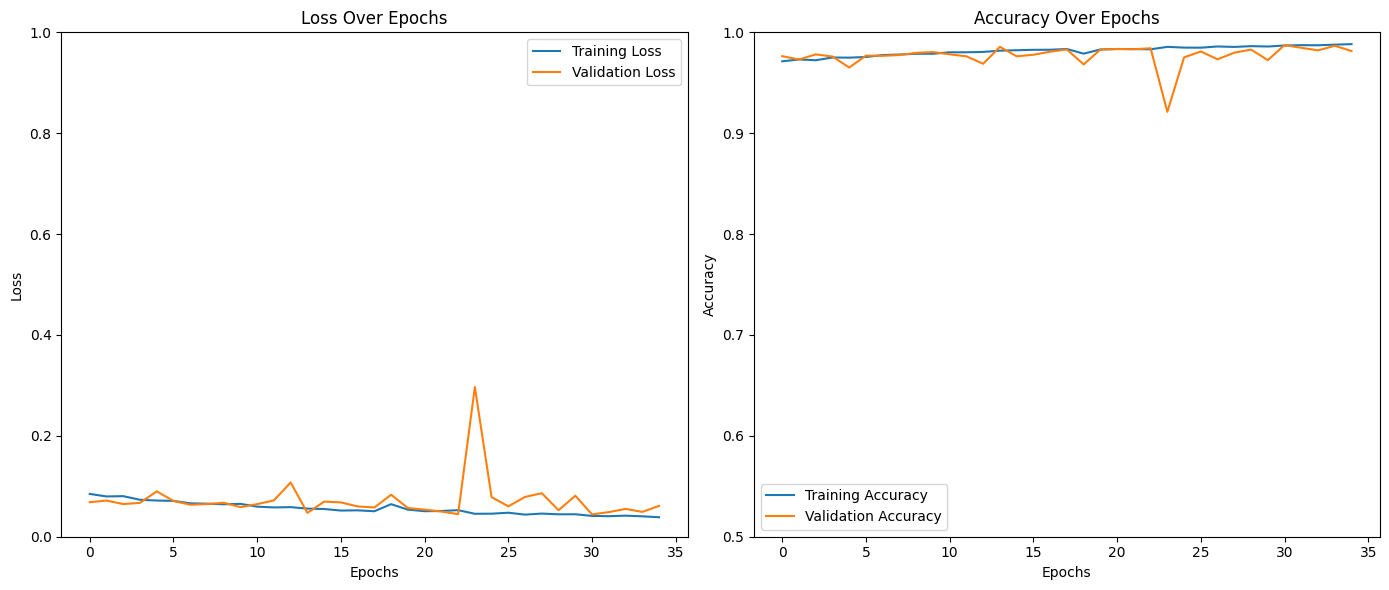

In [14]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(train_loss, label='Training Loss')
axs[0].plot(val_loss, label='Validation Loss')
axs[0].set_title('Loss Over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim(0.0, 1.0)
axs[0].legend()

axs[1].plot(train_acc, label='Training Accuracy')
axs[1].plot(val_acc, label='Validation Accuracy')
axs[1].set_title('Accuracy Over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim(0.5, 1.0)
axs[1].legend()

plt.tight_layout()
plt.show()

In [20]:
report = classification_report(
    y_train, model.predict(X_train).argmax(axis=1),
    target_names=['Walking', 'Jogging', 'Downstairs', 'Upstairs', 'Standing', 'Sitting', 'Sleeping']
)
print(report)

2391/2391 [==============================] - 5s 2ms/step
              precision    recall  f1-score   support

     Walking       0.98      0.94      0.96     10200
     Jogging       0.95      0.98      0.97     10200
  Downstairs       0.98      0.99      0.99     10200
    Upstairs       1.00      1.00      1.00     10200
    Standing       1.00      0.98      0.99     11900
     Sitting       0.98      1.00      0.99     11900
    Sleeping       1.00      1.00      1.00     11900

    accuracy                           0.99     76500
   macro avg       0.98      0.98      0.98     76500
weighted avg       0.99      0.99      0.98     76500



In [19]:
report = classification_report(
    y_test, model.predict(X_test).argmax(axis=1),
    target_names=['Walking', 'Jogging', 'Downstairs', 'Upstairs', 'Standing', 'Sitting', 'Sleeping']
)
print(report)

422/422 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

     Walking       0.97      0.93      0.95      1800
     Jogging       0.94      0.97      0.96      1800
  Downstairs       0.98      0.99      0.99      1800
    Upstairs       0.99      1.00      0.99      1800
    Standing       1.00      0.98      0.99      2100
     Sitting       0.98      1.00      0.99      2100
    Sleeping       1.00      1.00      1.00      2100

    accuracy                           0.98     13500
   macro avg       0.98      0.98      0.98     13500
weighted avg       0.98      0.98      0.98     13500



In [15]:
model_name = 'ActiveNetV2'

model.save(f'model/{model_name}.keras')
model = load_model(f'model/{model_name}.keras')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open(f'model/{model_name}.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\tailw\AppData\Local\Temp\tmp369qma1n\assets


INFO:tensorflow:Assets written to: C:\Users\tailw\AppData\Local\Temp\tmp369qma1n\assets
